TA MED LOW-NTF-GIDDENS!!!

# Plot temperature response over time

This notebook does the same as [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) except that it varies the ECS parameter and outputs a table of changes in temperature with respect to some reference year (defined below).

In [1]:
import pandas as pd

In [2]:
from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


**Output table found in:**

### General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) estimated from [Smith 2020](https://zenodo.org/record/3973015), by integrating with the impulse response function (IRF(t-t'))
#todo: check for ref for IRF
(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:


\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are from XXXXXX????

## Input data:
See [README.md](../../README.md)

# Code + figures

In [3]:
#fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2020_12_02_050025-1.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2021_02_02_025721.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'recommended_irf_from_2xCO2_2021_02_03_045947.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'recommended_irf_from_2xCO2_2021_02_07_223156.csv'

irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.713351,149.303493,1.333333,1.022558,0.904349,3.386835,281.99678,0.435308,0.314692,1.022558,3.0,1.801053,4.0


#fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2020_12_02_050025-1.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2021_02_02_025721.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2021_02_03_045947.csv'
irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
irf_consts  # [d1]

In [4]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'

PATH_DT_TAB_OUTPUT = RESULTS_DIR / 'tables' / 'table_sens_dT_cs_recommandetion.csv'
PATH_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

**Output table found in:**

In [5]:
print(PATH_DT_OUTPUT)

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP_recommendation.nc


## Imports:

In [6]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [7]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

## Set values:

ECS parameters:

In [8]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

Year to integrate from and to:

In [9]:
first_y = '1750'
last_y = '2100'

**Set reference year for temperature change:**

In [10]:
ref_year = '2020'

**Years to output change in**

In [11]:
years = ['2040', '2100']

## IRF:

In [12]:

def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

## ERF:
Read ERF from file

### Define variables to look at:

In [13]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-radiation_interactions',
    'aerosol-cloud_interactions',
    'aerosol-total',
    'o3',
    'HFCs',
    # 'F-Gases|HFC',
    'bc_on_snow',
    'total_anthropogenic',
    'total',
]
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = ['ssp534-over', 'ssp119', 'ssp460', 'ssp585', 'ssp370',
                'ssp370-lowNTCF-aerchemmip', 'ssp126', 'ssp245', 'ssp434',
                'ssp370-lowNTCF-gidden'
                ]

### Open dataset:

In [14]:
ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
da_ERF = ds['ERF']

# ds['time'] = \
# ds['year'].to_pandas().index.map('{}-01-01'.format)
ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')

# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})

## Integrate:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [15]:
name_deltaT = 'Delta T'


def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2]
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    # fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    # ds_DT.to_netcdf(fname)
    return ds_DT

## Compute $\Delta T$ with 3 different climate sensitivities

In [16]:
ds

<xarray.Dataset>
Dimensions:   (scenario: 10, variable: 19, year: 451)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2196 2197 2198 2199 2200
  * variable  (variable) object 'co2' 'ch4' ... 'aerosol-total-with_bc' 'HFCs'
  * scenario  (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'
Data variables:
    ERF       (scenario, variable, year) float64 ...
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2200-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

In [17]:
# noinspection PyStatementEffect
irf_consts.loc[recommendation][ld1]

3.3868348464180458

In [18]:
dic_ds = {}
for key in IRFpercentiles:
    dic_ds[key] = integrate_to_dT(ds, first_y, last_y, irf_consts.loc[key], int_var='ERF')

## check:

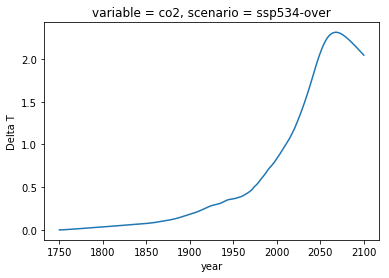

In [19]:
for per in IRFpercentiles:
    dic_ds[per].isel(scenario=0, variable=0)[name_deltaT].plot()

### Make datset with percentile as dimension:

In [20]:
ds_tmp = xr.Dataset(coords=dic_ds[recommendation].coords)
ds_tmp
for key in IRFpercentiles:
    ds_tmp[key] = dic_ds[key]['Delta T']  # .dims,dic_ds[key],)
ds['Delta T'] = ds_tmp.to_array('percentile')
ds.sel(year=slice(first_y, last_y)).to_netcdf(PATH_DT_OUTPUT)
# ds_DT.to_array('percentile')
# dic_ds[key]['Delta T']

## Table

### Setup table:

In [21]:

iterables = [list(IRFpercentiles), years]


def setup_table(scenario_n='', variables=variables_all):
    _i = pd.MultiIndex.from_product(iterables, names=['', ''])
    table = pd.DataFrame(columns= variables, index=_i).transpose()
    table.index.name = scenario_n
    return table

In [22]:
# Dicitonary of tables with different ESC:
scntab_dic = {}
for scn in scenarios_fl:
    # Loop over scenrarios
    tab = setup_table(scenario_n=scn, variables=variables_erf_comp)  # make table
    for var in variables_erf_comp:
        # Loop over variables
        tabvar = var.split('|')[-1]
        dtvar = name_deltaT
        for key in IRFpercentiles:
            # Loop over ESC parameters
            for year in years:
                _tab_da = dic_ds[key][dtvar].sel(scenario=scn, year=slice(year, year)) - dic_ds[key][dtvar].sel(
                    scenario=scn, year=slice(ref_year, ref_year)).squeeze()
                a = float(_tab_da.loc[var].squeeze().values)
                tab.loc[tabvar, (key, year)] = a
    scntab_dic[scn] = tab.copy()

In [23]:
from IPython.display import display

for key in scntab_dic:
    display(scntab_dic[key])

recommendation            
                                         2040        2100
ssp534-over                                              
ch4                                 0.0658166    -0.16726
aerosol-radiation_interactions      0.0344069 -0.00232192
aerosol-cloud_interactions          0.0865606    0.403743
aerosol-total                        0.120968    0.401421
o3                                  0.0426344   -0.132793
HFCs                                0.0426405   0.0151456
bc_on_snow                         0.00162298  -0.0412535
total_anthropogenic                  0.849906    0.883605
total                                0.805609    0.825799

recommendation            
                                         2040        2100
ssp119                                                   
ch4                                -0.0328498   -0.163074
aerosol-radiation_interactions      0.0300329   0.0390842
aerosol-cloud_interactions           0.271767    0.426961
aerosol-total                          0.3018    0.466045
o3                                 -0.0830983   -0.148473
HFCs                               0.00559328 -0.00401652
bc_on_snow                         -0.0280065  -0.0415275
total_anthropogenic                  0.397428    0.116036
total                                0.353131   0.0582305

recommendation           
                                         2040       2100
ssp460                                                  
ch4                                 0.0866686   0.179151
aerosol-radiation_interactions      0.0152394 -0.0219939
aerosol-cloud_interactions         -0.0357434   0.222835
aerosol-total                      -0.0205039   0.200841
o3                                  0.0558849  0.0937053
HFCs                                 0.038406  0.0410102
bc_on_snow                          0.0141988 -0.0225674
total_anthropogenic                  0.645718    2.26177
total                                 0.60142    2.20396

recommendation           
                                         2040       2100
ssp585                                                  
ch4                                 0.0618279   0.147478
aerosol-radiation_interactions      0.0344069 -0.0063042
aerosol-cloud_interactions          0.0865606    0.26812
aerosol-total                        0.120968   0.261816
o3                                  0.0400979  0.0506565
HFCs                                0.0426328   0.223788
bc_on_snow                         0.00162298 -0.0296496
total_anthropogenic                  0.836875    4.11427
total                                0.792577    4.05646

recommendation             
                                         2040         2100
ssp370                                                    
ch4                                 0.0761809     0.276651
aerosol-radiation_interactions      0.0128722  4.43553e-05
aerosol-cloud_interactions         -0.0854859   -0.0403596
aerosol-total                      -0.0726136   -0.0403152
o3                                  0.0698454     0.236445
HFCs                                0.0267615    0.0971195
bc_on_snow                          0.0205846    0.0136354
total_anthropogenic                  0.663786      3.15208
total                                0.619488      3.09427

recommendation           
                                         2040       2100
ssp370-lowNTCF-aerchemmip                               
ch4                                 0.0761809   0.276651
aerosol-radiation_interactions      0.0194731  0.0168867
aerosol-cloud_interactions          0.0696048   0.295293
aerosol-total                       0.0890779    0.31218
o3                                  0.0244954   0.157736
HFCs                                0.0267615  0.0971195
bc_on_snow                        -0.00202703 -0.0274264
total_anthropogenic                   0.75756    3.37383
total                                0.713263    3.31602

recommendation            
                                         2040        2100
ssp126                                                   
ch4                                -0.0208684    -0.15534
aerosol-radiation_interactions      0.0255283    0.047689
aerosol-cloud_interactions           0.226157    0.425775
aerosol-total                        0.251685    0.473464
o3                                 -0.0598631    -0.14714
HFCs                                0.0173057 -0.00167825
bc_on_snow                         -0.0233254  -0.0394008
total_anthropogenic                  0.505497    0.544207
total                                  0.4612    0.486401

recommendation            
                                         2040        2100
ssp245                                                   
ch4                                 0.0417628 -0.00104217
aerosol-radiation_interactions     0.00400846   0.0045108
aerosol-cloud_interactions          0.0450464    0.313308
aerosol-total                       0.0490549    0.317819
o3                                   0.014977  -0.0459325
HFCs                                0.0287474    0.057604
bc_on_snow                        -0.00242724   -0.035945
total_anthropogenic                  0.584779     1.75423
total                                0.540482     1.69643

recommendation            
                                         2040        2100
ssp434                                                   
ch4                                 0.0553451    0.125203
aerosol-radiation_interactions      0.0302367  0.00113449
aerosol-cloud_interactions          0.0391195    0.286926
aerosol-total                       0.0693562    0.288061
o3                                  0.0256502   0.0468623
HFCs                               0.00354016 -0.00755483
bc_on_snow                         0.00625439  -0.0275684
total_anthropogenic                  0.530424     1.08861
total                                0.486127     1.03081

recommendation           
                                         2040       2100
ssp370-lowNTCF-gidden                                   
ch4                                -0.0362155  -0.122362
aerosol-radiation_interactions      0.0194731  0.0168867
aerosol-cloud_interactions          0.0696048   0.295293
aerosol-total                       0.0890779    0.31218
o3                                 -0.0442151 -0.0985579
HFCs                                0.0267604   0.083795
bc_on_snow                        -0.00202703 -0.0274264
total_anthropogenic                  0.566941    2.64906
total                                0.522644    2.59126

### Make table with all scenarios:

In [24]:
iterables = [list(IRFpercentiles), years]
iterables2 = [scenarios_fl, variables_erf_comp]


def setup_table2():  # scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables, names=['', ''])
    _r = pd.MultiIndex.from_product(iterables2, names=['', ''])

    table = pd.DataFrame(columns=_r, index=_i).transpose()
    return table

In [25]:
tab = setup_table2()  # scenario_n=scn)

for scn in scenarios_fl:
    for var in variables_erf_comp:
        tabvar = var#.split('|')[-1]
        dtvar = name_deltaT
        for key in IRFpercentiles:
            for year in years:
                # compute difference between year and ref year
                _da_y = dic_ds[key][dtvar].sel(scenario=scn, year=slice(year, year), variable=var)  # .squeeze()
                _da_refy = dic_ds[key][dtvar].sel(scenario=scn, year=slice(ref_year, ref_year), variable=var).squeeze()
                # _tab_da = dic_ds[key][dtvar].sel(scenario=scn, time=slice(year,year))-  dic_ds[key][dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
                _tab_da = _da_y - _da_refy

                tab.loc[(scn, tabvar), (key, year)] = _tab_da.squeeze().values  # [0]

In [26]:
tab

recommendation  \
                                                                       2040   
                                                                              
ssp534-over           ch4                               0.06581660893277874   
                      aerosol-radiation_interactions   0.034406920882383424   
                      aerosol-cloud_interactions        0.08656062651392965   
                      aerosol-total                     0.12096754739631299   
                      o3                               0.042634433311539266   
...                                                                     ...   
ssp370-lowNTCF-gidden o3                               -0.04421511782025506   
                      HFCs                             0.026760390701908547   
                      bc_on_snow                      -0.002027027596469076   
                      total_anthropogenic                0.5669413931677021   
                      total                              0.5226442590299389   

                                                                              
                                                                        2100  
                                                                              
ssp534-over           ch4                               -0.16725956827439928  
                      aerosol-radiation_interactions  -0.0023219218621474136  
                      aerosol-cloud_interactions         0.40374341118226986  
                      aerosol-total                      0.40142148932012234  
                      o3                                 -0.1327931594749907  
...                                                                      ...  
ssp370-lowNTCF-gidden o3                                -0.09855791702674277  
                      HFCs                               0.08379495656608205  
                      bc_on_snow                        -0.02742636191202624  
                      total_anthropogenic                  2.649060659159763  
                      total                                 2.59125529021292  

[90 rows x 2 columns]

## Save output

In [27]:
tab.to_csv(PATH_DT_TAB_OUTPUT)

In [28]:
PATH_DT_TAB_OUTPUT

PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/results/tables/table_sens_dT_cs_recommandetion.csv')

## Double check historical $\Delta$ T: 


In [29]:
from matplotlib.ticker import (MultipleLocator)

from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic

<IPython.core.display.Javascript object>

In [30]:
ls_vars = ['aerosol-total', 'ch4', 'co2', 'other_wmghg', 'o3','HFCs']

In [31]:
cdic = get_cmap_dic(ls_vars)

/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [32]:
ds

<xarray.Dataset>
Dimensions:     (percentile: 1, scenario: 10, variable: 19, year: 451)
Coordinates:
  * year        (year) int64 1750 1751 1752 1753 1754 ... 2197 2198 2199 2200
  * variable    (variable) object 'co2' 'ch4' ... 'aerosol-total-with_bc' 'HFCs'
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'
  * percentile  (percentile) <U14 'recommendation'
Data variables:
    ERF         (scenario, variable, year) float64 ...
    time        (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2200-01-01
    delta_t     (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Delta T     (percentile, scenario, variable, year) float64 0.0 ... nan

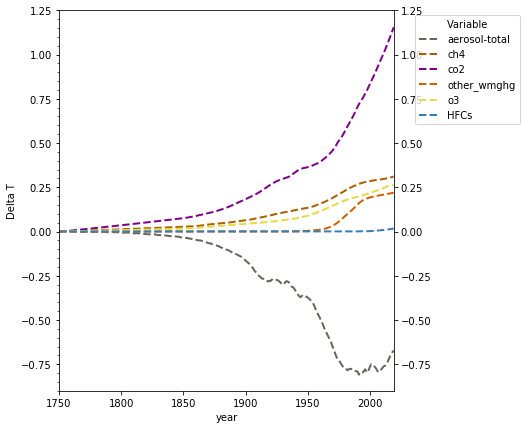

In [33]:

fig, ax = plt.subplots(figsize=[6, 7])

ds_hist = ds.sel(year=slice(1750, 2019), percentile=recommendation, scenario='ssp119', variable=ls_vars)
for var in ds_hist.variable.values:
    ds_hist.sel(variable=var)[name_deltaT].plot(label=var, linestyle='dashed', linewidth=2, c=cdic[var])
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')  # , prop=fontP)
ax.yaxis.set_major_locator(MultipleLocator(.25))
ax.yaxis.set_minor_locator(MultipleLocator(.05))
ax.tick_params(right=True, labelright=True)
ax.set_xlim([1750, 2019])
ax.set_ylim([-0.9, 1.25])
plt.title('')
plt.savefig('test.pdf')
plt.show()

In [34]:
da_ERF.scenario

<xarray.DataArray 'scenario' (scenario: 10)>
array(['ssp534-over', 'ssp370-lowNTCF-gidden', 'ssp119', 'ssp370', 'ssp434',
       'ssp460', 'ssp585', 'ssp126', 'ssp245', 'ssp370-lowNTCF-aerchemmip'],
      dtype=object)
Coordinates:
  * scenario  (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'